In [1]:
%matplotlib inline
import sys
import math
import numpy as np
import pandas
from matplotlib import pyplot
from mosthosts_desi import MostHostsDesi

## Finding all DESI observations of MostHosts objects

The MostHostsDesi class will match all of the RA/Dec from Mosthosts to the daily tables of observations from DESI.  It builds a (somewhat complicated) Pandas datastructure with all of the matches, and then writes that data structure to a csv file.  Look at that file for documentation on how it works.

In [ ]:
# To actually use this, you'll need to pass a database user and password.
# See the docstring on MostHostsDesi.__init__ for more information.
# Release can be "daily" or "everest"
# By default, this reads mosthosts_desi_{release}.csv from the local
#   directory.  Set force_regen=True to make it rebuild that file.
mhd = MostHostsDesi( release='daily', force_regen=False )

[2022-01-10 11:11:45,868 - WARNING] - Building mosthosts_desi_daily.csv from database.
[2022-01-10 11:11:45,886 - INFO] - Loading mosthosts table...
[2022-01-10 11:11:46,808 - INFO] - ...mosthosts table loaded.
[2022-01-10 11:11:46,809 - INFO] - Did 0 of 20174; 0 have at least 1 match
[2022-01-10 11:11:54,825 - INFO] - Did 1000 of 20174; 127 have at least 1 match
[2022-01-10 11:12:03,456 - INFO] - Did 2000 of 20174; 295 have at least 1 match
[2022-01-10 11:12:11,713 - INFO] - Did 3000 of 20174; 446 have at least 1 match
[2022-01-10 11:12:21,633 - INFO] - Did 4000 of 20174; 716 have at least 1 match
[2022-01-10 11:12:31,749 - INFO] - Did 5000 of 20174; 1024 have at least 1 match
[2022-01-10 11:12:42,143 - INFO] - Did 6000 of 20174; 1334 have at least 1 match
[2022-01-10 11:12:49,979 - INFO] - Did 7000 of 20174; 1447 have at least 1 match
[2022-01-10 11:12:57,905 - INFO] - Did 8000 of 20174; 1566 have at least 1 match
[2022-01-10 11:13:05,642 - INFO] - Did 9000 of 20174; 1663 have at lea

In [3]:
# Print out some statistics
print( f'...as of when the csv file was last regenerated:' )
print( f'{len(mhd.df)} entries in the MostHosts database' )
print( f'{len(mhd.df.groupby("snname"))} different SNe/AGN in MostHosts database' )
print( f'{len(mhd.haszdf)} hosts have at least one DESI zwarn=0 redshift' )
hostcounts = mhd.haszdf.reset_index().groupby("snname")["index"].count().rename("n")
print( f'{len(hostcounts)} SNe/AGN have at least one host observed by DESI' )

print()
hostcounts = hostcounts.groupby(hostcounts).count()
for n, counts in hostcounts.iteritems():
    print( f'{counts:4d} SNe/AGN have {n:2d} hosts with at least one zwarn=0 DESI redshift' )

# Make a version omitting the QSOs
print()
justsne = mhd.haszdf[ mhd.haszdf['program'].apply( lambda x: 'QSO' not in x ) ]
hostcounts = justsne.reset_index().groupby("snname")["index"].count().rename("n")
print( f'{len(hostcounts)} different SNe have at least one DESI zwarn=0 redshift' )

print()
hostcounts = hostcounts.groupby(hostcounts).count()
for n, counts in hostcounts.iteritems():
    print( f'{counts:4d} SNe have {n:2d} hosts with at least one zwarn=0 DESI redshift' )

...as of when the csv file was last regenerated:
20174 entries in the MostHosts database
14958 different SNe/AGN in MostHosts database
1090 hosts have at least one DESI zwarn=0 redshift
1048 SNe/AGN have at least one host observed by DESI

1012 SNe/AGN have  1 hosts with at least one zwarn=0 DESI redshift
  31 SNe/AGN have  2 hosts with at least one zwarn=0 DESI redshift
   4 SNe/AGN have  3 hosts with at least one zwarn=0 DESI redshift
   1 SNe/AGN have  4 hosts with at least one zwarn=0 DESI redshift

886 different SNe have at least one DESI zwarn=0 redshift

 850 SNe have  1 hosts with at least one zwarn=0 DESI redshift
  31 SNe have  2 hosts with at least one zwarn=0 DESI redshift
   4 SNe have  3 hosts with at least one zwarn=0 DESI redshift
   1 SNe have  4 hosts with at least one zwarn=0 DESI redshift


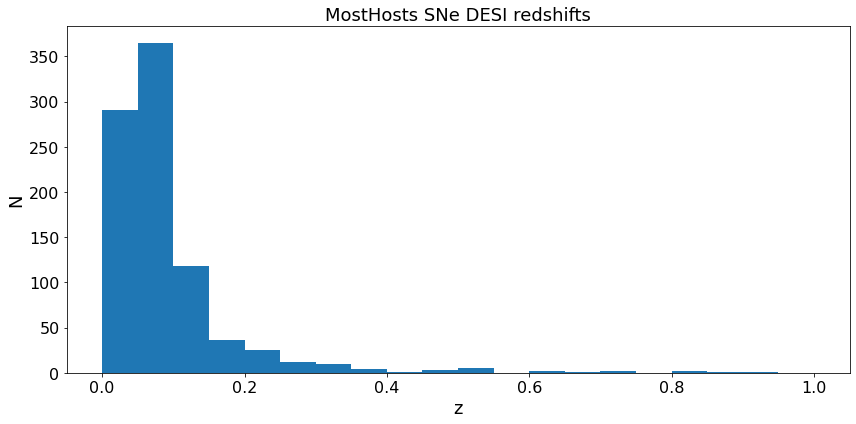

In [4]:
# Make a histogram of *independent* supernova zs.  I'm just going to take the first measurement
#  for each supernova... which may well not be the right one!

subframe = justsne.groupby( 'snname' ).agg('first')

# Let's make a histogram of those zs
fig = pyplot.figure( figsize=(12,6), tight_layout=True )
ax = fig.add_subplot(1, 1, 1)
ax.hist( subframe['z'], range=(0,1), bins=20)
ax.set_xlabel('z', fontsize=18)
ax.set_ylabel('N', fontsize=18)
ax.set_title( 'MostHosts SNe DESI redshifts', fontsize=18 )
#ax.set_yscale('log')
ax.tick_params( axis='both', labelsize=16 )
fig.show()
fig.savefig( 'mosthostsz.svg' )


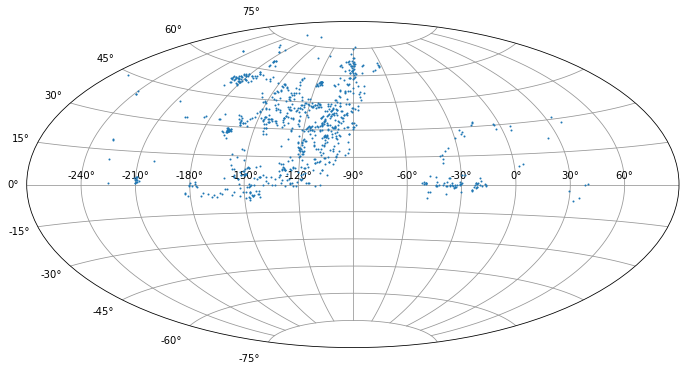

In [5]:
# Plot them on the sky
fig = pyplot.figure( figsize=(12,6) )
ax = fig.add_subplot(1, 1, 1, projection='aitoff' )
# I want to plot the aitoff projection not having 0 at the center
# I don't know if there's a simple argument to give to the axes for
# this, so I'll manually offset my RAs, and then manually edit the
# tick labels, to offset by raoff degrees.
raoff = 90
ras = ( subframe['ra'].values + raoff ) * math.pi/180.
ras[ ras < -math.pi ] = ras[ ras < -math.pi ] + 2*math.pi
ras[ ras >= math.pi ] = ras[ ras >= math.pi ] - 2*math.pi
ax.set_longitude_grid( 30 )
ax.set_latitude_grid( 15 )
ax.grid( which='major', color='#999999' )
ax.plot( ras, subframe['dec'].values*math.pi/180., linestyle='None', marker='o', markersize=1 )
fig.canvas.draw()
labels = [ f'{float(lab.get_text()[:-1])-raoff:.0f}°' for lab in ax.get_xticklabels() ]
ax.set_xticklabels( labels )
fig.show()
fig.savefig( 'mosthostdesiz_skydist.svg' )

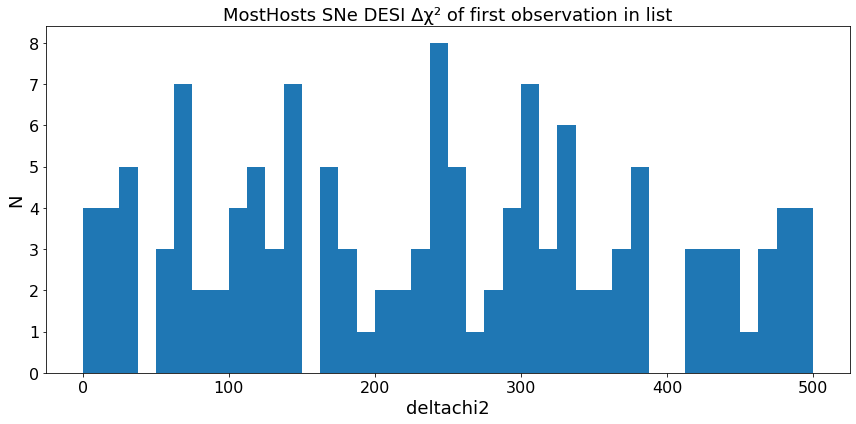

In [6]:
subframe = justsne.groupby( 'snname' ).agg('first')

fig = pyplot.figure( figsize=(12,6), tight_layout=True )
ax = fig.add_subplot(1, 1, 1)
ax.hist( subframe['zpix_deltachi2'].apply( lambda x: x[0] ).values, range=(0,500), bins=40)
ax.set_xlabel('deltachi2', fontsize=18)
ax.set_ylabel('N', fontsize=18)
ax.set_title( 'MostHosts SNe DESI Δχ² of first observation in list', fontsize=18 )
#ax.set_yscale('log')
ax.tick_params( axis='both', labelsize=16 )
fig.show()


In [7]:
subframe = justsne.groupby( 'snname' ).agg('first')
dexes = subframe.index.values
ztfobjs = subframe[ [ it[0:3]=='ZTF' for it in dexes ] ]
# I know I could have done a pandas count something something,
# but I might want this subframe later.
print( f"There are {len(subframe)} SNe with DESI-observed hosts whose names start with \"ZTF\"" )

There are 886 SNe with DESI-observed hosts whose names start with "ZTF"


In [8]:
ztfobjs['program'].unique()

array(['SNe_Ia', 'SNe_Ia/ZTFmarshal', 'RCF', 'ZTFmarshal',
       'SNe_Ia/RCF/ZTFmarshal', 'RCF/ZTFmarshal', 'SNe_Ia/RCF',
       'IIps/ZTFmarshal', 'RCF/IIps/ZTFmarshal', 'SNe_Ia/IIps/ZTFmarshal',
       'SNe_Ia/RCF/IIps/ZTFmarshal', 'Anna/ZTFmarshal'], dtype=object)

In [9]:
# ztfobjs['program'].values is an object, not a string, so this is convolted
ztfsne = ztfobjs[ np.char.find( np.array( ztfobjs['program'].values, dtype=str ), 'SNe_Ia' ) >= 0 ]
print( f'There are {len(ztfsne)} SNe with program including "SNe_Ia" that are observed by DESI and that have names starting with "ZTF"' )

There are 248 SNe with program including "SNe_Ia" that are observed by DESI and that have names starting with "ZTF"


In [11]:
justptf = justsne[ justsne['ptfiptf_name'] != 'None' ]
justptf.columns

Index(['snname', 'ra', 'dec', 'pmra', 'pmdec', 'ref_epoch', 'override',
       'hemisphere', 'sn_ra', 'sn_dec', 'sn_z', 'program', 'priority',
       'tns_name', 'iau_name', 'ptfiptf_name', 'zpix_targetid',
       'zpix_nowarn_targetid', 'zpix_z', 'zpix_nowarn_z', 'zpix_zerr',
       'zpix_nowarn_zerr', 'zpix_zwarn', 'zpix_nowarn_zwarn', 'zpix_spectype',
       'zpix_nowarn_spectype', 'zpix_subtype', 'zpix_nowarn_subtype',
       'zpix_deltachi2', 'zpix_nowarn_deltachi2', 'z', 'dz', 'zdisp'],
      dtype='object')

In [12]:
pandas.options.display.max_rows = 500
justptf[ ['ptfiptf_name', 'ra', 'dec', 'zpix_nowarn_z'] ]

,,ptfiptf_name,ra,dec,zpix_nowarn_z
spname,index,,,,
PTF09alu,1.0,PTF09alu,214.572816,53.788987,"[0.0744134527379306, 0.0744549097489034]"
PTF09aus,1.0,PTF09aus,225.231327,-0.192354,[0.0411256227411747]
PTF09bad,2.0,PTF09bad,244.010525,56.346198,[0.138983835216883]
PTF09bw,1.0,PTF09bw,226.247542,48.646639,[0.0244531750511241]
PTF09dih,2.0,PTF09dih,227.570601,43.730332,[0.119091523955735]
PTF09dnl,1.0,PTF09dnl,260.923780,30.497379,[0.0233423766604496]
PTF09dnp,1.0,PTF09dnp,229.855667,49.501306,[0.0373691297359225]
PTF09dyp,1.0,PTF09dyp,331.820438,5.040449,[0.140224414651586]
PTF09fr,1.0,PTF09fr,222.499032,44.917192,[0.0798720381609873]
